#Question 9
Image classification task using Niave Bayes and logistic regression classifier. 
1. Download a dataset from https://www.kaggle.com/c/dogs-vs-cats/data . (2 points)
2. Randomly sample the images to create a cat and dog training sets consisting of 70% of the images. Rest 30% images form the testing images. (1 point)
3. Build Naive Bayes classifier for cat and dog images. Use intensity and SVD based features for these classifiers. (2 points)
4. Build a logistic regression based classifier for cat and dog images. Use intensity and SVD based features for these classifiers. (2 points)
5. Calculate accuracy for the training set and testing set for the above classifiers, for both intensity and SVD based features and confusion matrix. (4 points)
7. Compare the performance of the above classifiers and report your observations. (2 points)

In [2]:
##Question 9 Part 1

from kaggle.api.kaggle_api_extended import KaggleApi
import os
import sys

## Import kaggle config (username and API KEY)from ~/.kaggle/kaggle.json
api  = KaggleApi()
api.authenticate()
dirname = os.getcwd()
filename = os.path.join(dirname, 'data')
api.competition_download_files('dogs-vs-cats',path=filename,force=False,quiet=False)

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
## Extract archive files (train.zip and test1.zip) to ./data
import zipfile
os.chdir(filename)
abs_list_of_files_name = []
for item in os.listdir(filename):
    if zipfile.is_zipfile(item):
        with zipfile.ZipFile(item, 'r') as file:
            for member in file.infolist():
                if member.filename[-1] == '/':
                    continue
                abs_list_of_files_name.append(filename + "/" + member.filename)
            file.extractall()

In [4]:
## Get from absolute files names class label for the image
import re
training_list = []
test_list = []
for elem in abs_list_of_files_name :
    train_match = re.search(r'train',elem)
    if train_match:
        training_list.append(elem)
    test_match = re.search(r'test1',elem)
    if test_match:
        test_list.append(elem) 

25000
12500


In [9]:
#Create a trainng catalog dataset
import numpy as np
import pandas as pd

#Convert List to 1D numpy Array
train_list_1darray = np.array(training_list)
training_df = pd.DataFrame(train_list_1darray,columns=['filepath']) 
training_df['filename'],training_df['category'] = training_df['filepath'].apply(lambda x: os.path.basename(x)),training_df['filepath'].apply(lambda x: os.path.basename(x).split('.')[0])
#training_df[~training_df['category'].isin(['cat','dog'])]

,filepath,filename,category


In [57]:
#Create a test catalog dataset
test_list_1darray = np.array(test_list) 
test_df = pd.DataFrame(test_list_1darray,columns=['filepath']) 
test_df['filename'],test_df['category'] = test_df['filepath'].apply(lambda x: os.path.basename(x)),test_df['filepath'].apply(lambda x: os.path.basename(x).split('.')[0])

####Feature extraction from a single image

In [11]:
%matplotlib inline
from PIL import Image
from sklearn import preprocessing
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [13]:
## Build a list of tuples of (height,width) for all images
##import opencv library
import cv2

## Returns tuple 
##output: the image height,width

def image_dimensions(imgloc):
    img = cv2.imread(imgloc)
    return (img.shape[0],img.shape[1])

training_img_2Ddimension = [image_dimensions(x) for x in training_df['filepath']]
test_img_2Ddimension = [image_dimensions(x) for x in test_df['filepath']]

In [14]:
## logic to resize the images
## automate to select proper height and width
## start with an initial height width 
## iteriate to adjust if discard ratio > 0.01
## if discard_ratio > 0.01 then height = 0.9 * height and width = width * 0.9

import math
def resize_height_width(result,ratio):
    discard_ratio = 0
    fixed_height_to_resize = 500
    fixed_width_to_resize = 500
    discard_list = []
    while True:
        outlist = [ 1 if x[0] >=fixed_height_to_resize and x[1] >= fixed_width_to_resize else 0 for x in result]
        discard_ratio = outlist.count(0) / outlist.count(1)
        if discard > ratio :
            fixed_width_to_resize  = math.floor(0.9 * fixed_width_to_resize)
            fixed_height_to_resize = math.floor(0.9 * fixed_height_to_resize)
        else:
            discard_list = outlist
            break
    return discard_list

In [ ]:
## add a dataframe column(include) to track if a image is resizeable or rejected for a height width 
discard_list = []
discard_list = resize_height_width(training_img_2Ddimension,0.001)
training_df['include'] = pd.Series(discard_list).values
## copy original dataframe to create a subset dataframe for all image that have include = 1
training_df_subset = training_df[training_df['include']==1].copy()

In [ ]:
## add a dataframe column(include) to track if a image is resizeable or rejected for a height width 
discard_list = []
discard_list = resize_height_width(test_img_2Ddimension,0.001)
test_df['include'] = pd.Series(discard_list).values
## copy original dataframe to create a subset dataframe for all image that have include = 1
test_df_subset = training_df[training_df['include']==1].copy()

In [17]:
## Resize image to fixed_width_to_resize , fixed_height_to_resize 
## convert to grayscale 
## return singular numpy 1Darray
def image_resize_convert(imgpath,fixed_height_to_resize,fixed_width_to_resize):
    img = Image.open(imgpath)
    img = img.resize((fixed_height_to_resize, fixed_width_to_resize))
    imggray = img.convert('L')
    filename = os.path.basename(imgpath)
    filepath = os.path.dirname(imgpath)
    newfilepath = filepath + "/100_" +filename 
    #new_image.save(newfilepath)
    imgmat = np.array(list(imggray.getdata(band=0)), float)
    imgmat.shape = (fixed_height_to_resize, fixed_width_to_resize)
    imgmat = np.matrix(imgmat)
    U, sigma, V = np.linalg.svd(imgmat)
    img.close()
    return sigma

In [18]:
## Build a numpy 1D array list of singular values 
global_SVD = [image_resize_convert(x,fixed_height_to_resize,fixed_width_to_resize) for x in newdf['filepath']]
## label list
global_label = [ os.path.basename(x).split('.')[0] for x in newdf['filepath'] ]
global_category = [ 1 if x == 'cat' else 0 for x in global_label]
## Convert to dataframe 
## Normalize the dataframe
## Assign label to each row in dataframe
train_numpy_2darray = np.array(global_SVD)
train_numpy_2darray_normalized = preprocessing.normalize(train_numpy_2darray, norm='l2')
#train_svd_df = pd.DataFrame(train_numpy_2darray_normalized)
#train_svd_df['category'] = pd.Series(global_category).values


In [43]:
train_category_1darray = np.array(global_category) 

In [39]:
## Import libraries for training models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

##--------------------
## tunable-parameters
##--------------------
test_size = 0.10
seed      = 9
scoring   = "accuracy"

In [50]:
## train model using train_numpy_2darray_normalized  and global_category
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('NB', GaussianNB()))

## variables to hold the results and names
results = []
names   = []

In [51]:
# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(train_numpy_2darray_normalized.shape))
print("[STATUS] labels shape: {}".format(train_category_1darray.shape))

print("[STATUS] training started...")

[STATUS] features shape: (24825, 99)
[STATUS] labels shape: (24825,)
[STATUS] training started...


In [52]:
# 10-fold cross validation
import warnings
warnings.filterwarnings('ignore')
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, train_numpy_2darray_normalized, train_category_1darray, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.444706 (0.037895)
NB: 0.601850 (0.214963)


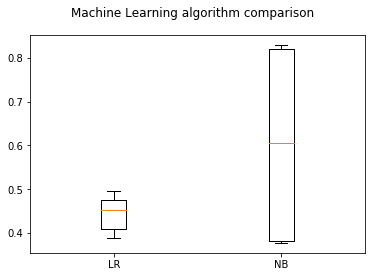

In [53]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
#-----------------------------------
# TESTING OUR MODEL
#https://gogul09.github.io/software/image-classification-python
#https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/
#https://learning.oreilly.com/library/view/mastering-opencv-4/9781789344912/9c91ee0b-2fab-4972-a4d5-f3e6cdae8c47.xhtml
#https://www.frankcleary.com/svdimage/
#https://auth0.com/blog/image-processing-in-python-with-pillow/
#-----------------------------------

# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(train_numpy_2darray_normalized, train_category_1darray)

#y_pred=logreg.predict(X_test)